<a href="https://colab.research.google.com/github/KissTK322/Ai-Builder-2023/blob/main/Chula_Parasite_Egg_Detection_V_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Library

In [32]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO


#Modify Dataset Class for CoCo

In [33]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path))

        num_objs = len(coco_annotation)

        boxes = []
        category_ids = [] 
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            category_ids.append(coco_annotation[i]['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        category_ids = torch.as_tensor(category_ids, dtype=torch.int64)
        img_id = torch.tensor([img_id])

        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["image_id"] = img_id
        my_annotation["category_id"] = category_ids

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)


#Get Transform

In [34]:

def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)


#Setup own DataLoader

In [35]:
train_data_dir = '/content/drive/MyDrive/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data'
train_coco = '/content/drive/MyDrive/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/labels.json'


my_dataset = myOwnDataset(root=train_data_dir,
                             annotation=train_coco,
                             transforms=get_transform())

def collate_fn(batch):
    images = []
    annotations = []
    for image, annotation in batch:
        images.append(image)
        annotations.append(annotation)
    return images, annotations

train_batch_size = 32

data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


#Check DataLoader

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i, (images, annotations) in enumerate(data_loader):
    for j in range(len(images)):
        image = images[j]
        annotation = annotations[j]
        boxes = annotation['boxes'].cpu().numpy()
        labels = annotation['image_id']
        category_ids = annotation['category_id']
        plt.imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
        for box, label, category_id in zip(boxes, labels, category_ids):
            xmin, ymin, xmax, ymax = box
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                               fill=False, edgecolor='r', linewidth=2))
            plt.text(xmin, ymin, f'{category_id} : {label}', bbox=dict(facecolor='r', alpha=0.5))
        plt.show()


#New New Run

In [36]:
import torchvision
import torch.optim as optim
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = len(my_dataset.coco.cats)
print(num_classes)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=0.001)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

def my_faster_rcnn_loss(outputs, targets):
    outputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in outputs.items()}
    targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
    loss_dict = model.roi_heads.forward(outputs, targets)
    return sum(loss_dict.values())

import tqdm

model.train()
model.to(device)
num_epochs = 1

for epoch in range(num_epochs):
    progress_bar = tqdm.tqdm(data_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.set_postfix(loss=losses.item())



11


Epoch 1/1: 100%|██████████| 11000/11000 [1:05:51<00:00,  2.78it/s, loss=0.173]


In [37]:

model_save_path = '/content/drive/MyDrive/Chula-ParasiteEgg-11/model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to /content/drive/MyDrive/Chula-ParasiteEgg-11/model.pth


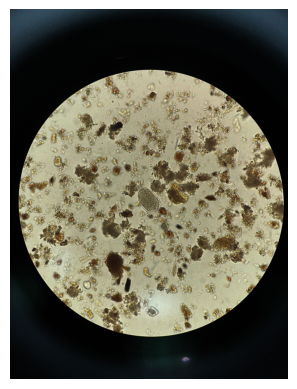

In [62]:
import os
import torch
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

# Load the saved model
model_save_path = '/content/drive/MyDrive/Chula-ParasiteEgg-11/model.pth'
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
num_classes = len(my_dataset.coco.cats)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load(model_save_path))
model.to(device)
model.eval()

# Define the function to perform inference on a test image
def predict(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = get_transform()
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        predictions = model(image_tensor)
    
    boxes = predictions[0]["boxes"].cpu().numpy().tolist()
    labels = predictions[0]["labels"].cpu().numpy().tolist()

    # Convert labels to category IDs
    category_ids = [my_dataset.coco.getCatIds()[label] for label in labels]

    return boxes, category_ids

# Set the path to the test image
test_image_path = '/content/drive/MyDrive/test/data/0059.jpg'

# Perform prediction on the test image
predicted_boxes, predicted_category_ids = predict(test_image_path)

# Plot the test image with predicted bounding boxes
image = Image.open(test_image_path)
plt.imshow(image)
ax = plt.gca()

for box, category_id in zip(predicted_boxes, predicted_category_ids):
    xmin, ymin, xmax, ymax = box
    width = xmax - xmin
    height = ymax - ymin
    rect = plt.Rectangle((xmin, ymin), width, height, fill=False, edgecolor='r', linewidth=2)
    ax.add_patch(rect)
    ax.text(xmin, ymin, str(category_id), bbox=dict(facecolor='r', alpha=0.5))

plt.axis('off')
plt.show()



#Prediction

In [63]:

import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load the saved model
num_classes = len(my_dataset.coco.cats)
model = fasterrcnn_resnet50_fpn(pretrained=False, num_classes=num_classes)
model.load_state_dict(torch.load('/content/drive/MyDrive/Chula-ParasiteEgg-11/model.pth', map_location=torch.device('cpu')))

# Set the model to evaluation mode
model.eval()

# Load the test image
image = Image.open('/content/drive/MyDrive/test/data/0059.jpg').convert('RGB')

# Apply transformations to the image
transform = T.Compose([T.ToTensor()])
image = transform(image)

# Add a batch dimension to the image
image = image.unsqueeze(0)

# Make predictions
with torch.no_grad():
    predictions = model(image)

# Iterate over the predictions
print(predictions)
print(image)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[{'boxes': tensor([], size=(0, 4)), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([])}]
tensor([[[[0.1490, 0.1647, 0.1961,  ..., 0.0706, 0.1725, 0.1725],
          [0.1529, 0.1569, 0.3059,  ..., 0.0941, 0.1490, 0.1294],
          [0.2471, 0.0706, 0.0039,  ..., 0.0784, 0.1176, 0.1059],
          ...,
          [0.0078, 0.0078, 0.0078,  ..., 0.0353, 0.0196, 0.0118],
          [0.0000, 0.0000, 0.0000,  ..., 0.0275, 0.0118, 0.0078],
          [0.0000, 0.0000, 0.0000,  ..., 0.0118, 0.0078, 0.0118]],

         [[0.2353, 0.2471, 0.2706,  ..., 0.0510, 0.1373, 0.1294],
          [0.2392, 0.2392, 0.3804,  ..., 0.0941, 0.1373, 0.1098],
          [0.3333, 0.1529, 0.0784,  ..., 0.1020, 0.1412, 0.1255],
          ...,
          [0.0157, 0.0157, 0.0157,  ..., 0.0431, 0.0275, 0.0196],
          [0.0039, 0.0039, 0.0039,  ..., 0.0353, 0.0196, 0.0157],
          [0.0078, 0.0078, 0.0078,  ..., 0.0196, 0.0157, 0.0196]],

         [[0.1843, 0.2196, 0.2863,  ..., 0.1686, 0.2588, 0.2549],
        